In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import json
# import keras
import geojson
import rasterio
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

import shapely
from shapely.geometry import shape
from shapely.geometry import MultiPolygon, Polygon, mapping
from shapely.ops import unary_union

# from keras.models import Model, model_from_config, load_model

from aeronet.dataset import BandCollection, polygonize
from aeronet.dataset.utils import parse_directory
from aeronet.converters.split import split
#from aeronet.dataset.io import SequentialSampler, SampleCollectionWindowWriter
from aeronet.dataset import RandomDataset, dataset
from aeronet.dataset.visualization import add_mask

# from segmentation_models import Unet
# from segmentation_models.metrics import jaccard_score

import albumentations as alb
import aeronet.dataset as ds

# Data preprocessing

In [2]:
# constants
DATA_DIR = '/home/sergei/remote_sensing/mapbox/train/'
VAL_DIR = '/home/sergei/remote_sensing/mapbox/val/'

CHANNELS = ['RED', 'GRN', 'BLU']
GT_LABELS = ['301', '302', '307']
PRED_LABELS = ['301', '302']

In [3]:
# Routines for data import
def read_bcs(root_dir, labels):
    bcs = []
    for dse in os.listdir(root_dir):
        src_dir = os.path.join(root_dir, dse)
        pathes = ds.parse_directory(src_dir, labels)
        bc = ds.BandCollection(pathes)
        bcs.append(bc)
    return bcs

def _read_bc(directory, names):
    pathes = ds.parse_directory(directory, names)
    bc = ds.BandCollection(pathes)
    return bc

def _read_fcs(directory, names, crs=None):
    pathes = [os.path.join(directory, '{}.geojson'.format(name)) for name in names]
    fcs = [ds.FeatureCollection.read(path) for path in pathes]
    if crs is not None:
        fcs = [fc.reproject(crs) for fc in fcs]
    return fcs

In [4]:
train_data = read_bcs(DATA_DIR, CHANNELS + GT_LABELS)

In [5]:
valid_data = {}

for valid_id in os.listdir(VAL_DIR):
    
    src_dir = os.path.join(VAL_DIR, valid_id) 
    print(src_dir)
    valid_data[valid_id] = {
        'x': _read_bc(src_dir, CHANNELS),
        'y_raster': _read_bc(src_dir, GT_LABELS).ordered(*GT_LABELS),
    }

/home/sergei/remote_sensing/mapbox/val/23_4
/home/sergei/remote_sensing/mapbox/val/10_4
/home/sergei/remote_sensing/mapbox/val/1_3
/home/sergei/remote_sensing/mapbox/val/3_5
/home/sergei/remote_sensing/mapbox/val/16_2
/home/sergei/remote_sensing/mapbox/val/14_3
/home/sergei/remote_sensing/mapbox/val/12_3
/home/sergei/remote_sensing/mapbox/val/21_1
/home/sergei/remote_sensing/mapbox/val/8_2
/home/sergei/remote_sensing/mapbox/val/17_4
/home/sergei/remote_sensing/mapbox/val/23_3
/home/sergei/remote_sensing/mapbox/val/6_4
/home/sergei/remote_sensing/mapbox/val/5_1
/home/sergei/remote_sensing/mapbox/val/19_4
/home/sergei/remote_sensing/mapbox/val/8_1


In [6]:
def extract_train(sample):
    x = sample['x'].numpy()
    y = sample['y_raster'].numpy()
    return x, y

# class 301 - asphalt
# class 302 - dirt
# class 307 - all

def extract_data(bc):
    x = bc['x'].numpy().transpose(1,2,0)
    y = bc['y_raster'].numpy()
    
    idx_asphalt = (y[0] != 0)
    idx_dirt = (y[1] != 0)

    x_asphalt = x[idx_asphalt]
    x_dirt = x[idx_dirt]

    y_asphalt = np.zeros(x_asphalt.shape[0], dtype = np.uint8)
    y_dirt = np.ones(x_dirt.shape[0], dtype = np.uint8)
    
    return x_asphalt, y_asphalt, x_dirt, y_dirt

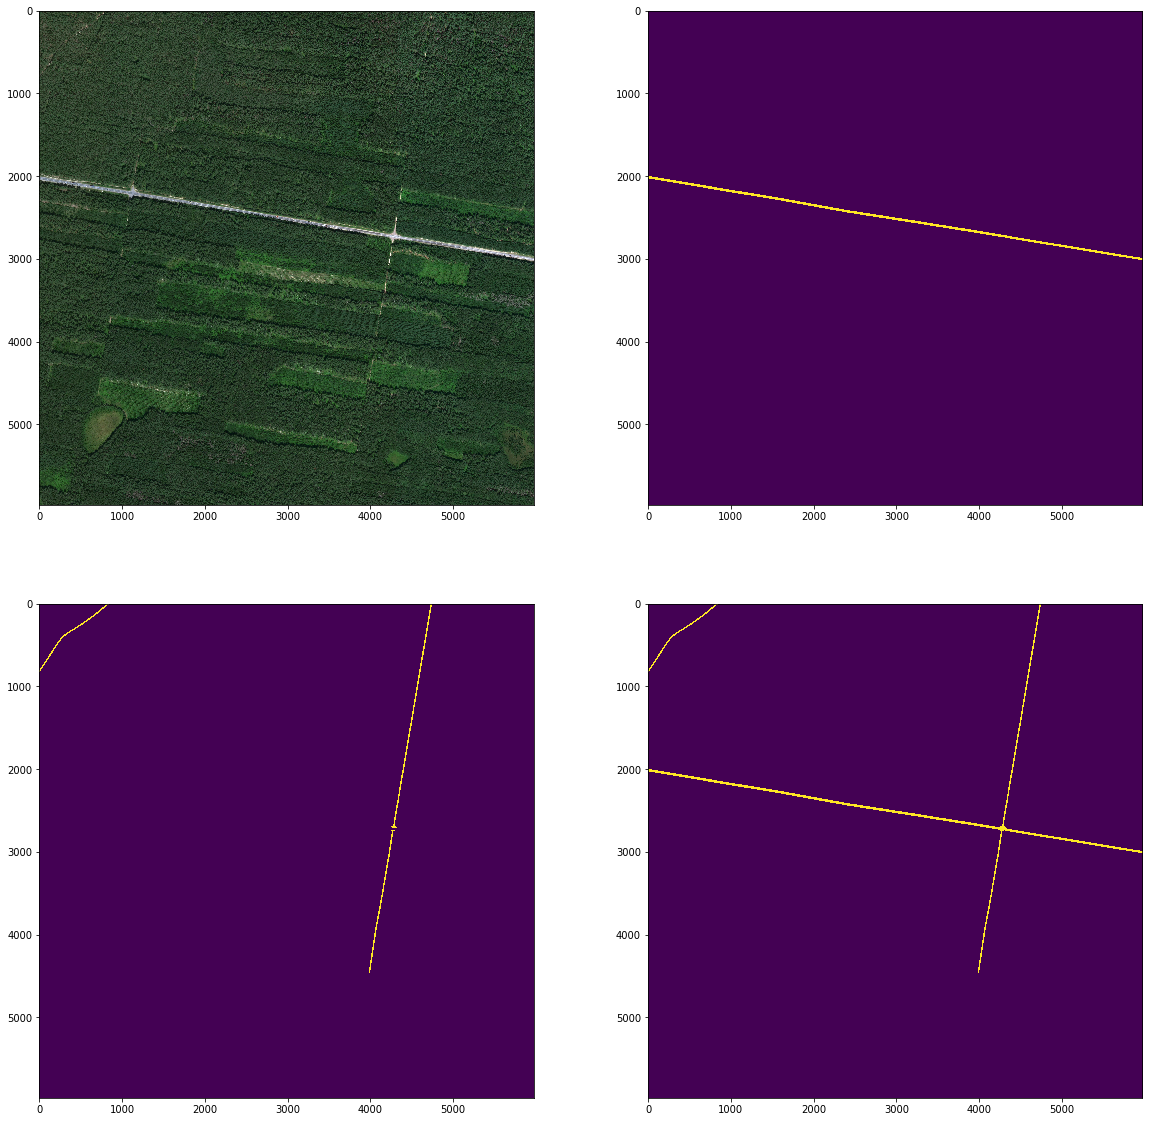

In [7]:
x , y = extract_train(valid_data['1_3'])


plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(x.transpose(1,2,0))

plt.subplot(222)
plt.imshow(y[0])

plt.subplot(223)
plt.imshow(y[1])

plt.subplot(224)
plt.imshow(y[2])

plt.show()

In [7]:
# extract all the data to the train:
x_all = None
y_all = None

for bc in valid_data.values():
    x_asphalt, y_asphalt, x_dirt, y_dirt = extract_data(bc)
    if x_all is None:
        x_all = x_asphalt
        x_all = np.concatenate((x_all, x_dirt))
    else:
        x_all = np.concatenate((x_all, x_asphalt))
        x_all = np.concatenate((x_all, x_dirt))
    if y_all is None:
        y_all = y_asphalt
        y_all = np.concatenate((y_all, y_dirt))
    else:
        y_all = np.concatenate((y_all, y_asphalt))
        y_all = np.concatenate((y_all, y_dirt))

In [8]:
# # extract one sample of the data to the train:
# x_all = None
# y_all = None

# bc = valid_data['1_3']
# x_asphalt, y_asphalt, x_dirt, y_dirt = extract_data(bc)
# if x_all is None:
#     x_all = x_asphalt
#     x_all = np.concatenate((x_all, x_dirt))
# else:
#     x_all = np.concatenate((x_all, x_asphalt))
#     x_all = np.concatenate((x_all, x_dirt))
# if y_all is None:
#     y_all = y_asphalt
#     y_all = np.concatenate((y_all, y_dirt))
# else:
#     y_all = np.concatenate((y_all, y_asphalt))
#     y_all = np.concatenate((y_all, y_dirt))

In [9]:
print( "x_all shape:", x_all.shape)
print( "y_all shape:", y_all.shape)

x_all shape: (17240240, 3)
y_all shape: (17240240,)


In [10]:
# Select all
x = x_all
y = y_all

In [11]:
# Select subset
size_of_subset = 10000

row_i = np.random.choice(x_all.shape[0], size = size_of_subset)
x = x_all[row_i, :]
y = y_all[row_i]

print( "x shape:", x.shape)
print( "y shape:", y.shape)

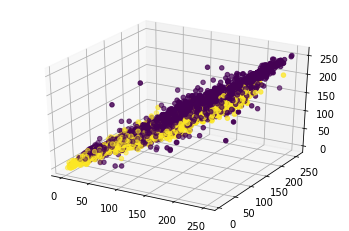

In [71]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = x[:, 2]
xdata = x[:, 0]
ydata = x[:, 1]

ax.scatter3D(xdata, ydata, zdata, c=y, cmap='viridis');

# ML models testing

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import time

from joblib import dump, load

import os

In [14]:
# Directory for trained models
MODELS_DIR = '/home/sergei/remote_sensing/Models/'

In [15]:
def test_clf(clf, clf_name, x, y, path):
    
    # counter
    i = 0
    
    os.chdir(path)
    start_time = time.time()
    
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    
    # Open logs
    f= open("Results " + clf_name + ".txt","w+")
    
    f.write("Classifier: "+ clf_name + '\n')
    f.write('\n')
    f.write("Cross validation score:\n")
    f.write('\n')
    
    print("Classifier:", clf_name)
    print('')
    print("Cross validation score:")
    print('')

    for train_index, test_index in cv.split(x, y):
        
        #Split test and train
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit classifier and score it
        clf.fit(x_train, y_train)
        score = "{:.2f}".format(roc_auc_score(y_test, clf.predict(x_test)))
        
        f.write("ROC score " + str(i) + " :" + score + '\n')
        print ("ROC score " + str(i) + " :" + score)
        
        # Save classifier 
        dump(clf, "clf_" + clf_name + str(i) + ".joblib")
        i += 1

        milli_sec = int(round((time.time() - start_time) * 1000))

    sec = round((time.time() - start_time))
    
    f.write('\n')
    f.write("Time of execution, sec:" + str(sec))
    
    print('')
    print("Time of execution, sec:", sec)
    
    f.close()

## First tests

In [ ]:
kernel = 'linear'
clf = SVC(kernel = kernel)
test_clf(clf, "SVM " + kernel, x, y, MODELS_DIR + "/SVM/")

In [ ]:
n = 5
clf = KNeighborsClassifier(n_neighbors = n)
test_clf(clf, "KNN n_neighbors = " + str(n), x, y, MODELS_DIR + "/KNN/")

In [94]:
depth = 3
clf = tree.DecisionTreeClassifier(max_depth = depth)
test_clf(clf, "Decision tree depth = " + str(depth), x, y, MODELS_DIR + "/Dtree/")

Classifier: Decision tree depth = 3

Cross validation score:

ROC score 0 :0.54
ROC score 1 :0.54
ROC score 2 :0.55
ROC score 3 :0.55
ROC score 4 :0.55

Time of execution, sec: 0


In [95]:
n_est = 50
forest = RandomForestClassifier(n_estimators = n_est, n_jobs=-1, random_state=17)
test_clf(clf, "Random forest n_est = " + str(n_est), x, y, MODELS_DIR + "/Rforest/")

Classifier: Random forest n_est = 50

Cross validation score:

ROC score 0 :0.54
ROC score 1 :0.54
ROC score 2 :0.54
ROC score 3 :0.56
ROC score 4 :0.56

Time of execution, sec: 0


# Test SVM with more complex kernels

In [ ]:
# Select subset
size_of_subset = 100

row_i = np.random.choice(x_all.shape[0], size = size_of_subset)
x = x_all[row_i, :]
y = y_all[row_i]

print( "x shape:", x.shape)
print( "y shape:", y.shape)

In [ ]:
# Test SVM with more complex kernels (start with less data)
for kernel in ('poly', 'rbf'):
    clf = SVC(kernel = kernel, gamma = 2)
    test_clf(clf, "SVM " + kernel, x, y, MODELS_DIR + "/SVM/")